In [1]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet as pr
#import mplcursors
from datetime import datetime

Matplotlib created a temporary config/cache directory at C:\Users\MATHEU~1\AppData\Local\Temp\matplotlib-m9dn49rz because the default path (C:\Users\Matheus Alves\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
C:\Users\Matheus Alves\OneDrive\Documentos\GIT\TCC\tcc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style("darkgrid")
%matplotlib inline

## Carregando Base de Dados, Dividindo entre Teste e Treino e Alterando para Padrão Prophet


In [4]:
rainfall = pd.read_csv(r"C:\Users\Matheus Alves\OneDrive\Documentos\GIT\TCC\time_series_precipitation\Dataset\dados_chuvas1.csv", parse_dates=True)

In [5]:
rainfall['Date'] = pd.to_datetime(rainfall['Date'], format="%Y/%m/%d")
#rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

In [6]:
train = rainfall.iloc[:-14]
test = rainfall.iloc[-14:]

In [7]:
 train.columns = ['ds','y']

## Instanciando Prophet e Fazendo uma Previsão com Ajustes Para o Verão e Sazonalidade Quadrimestral

In [8]:
rainfall['month'] = pd.DatetimeIndex(rainfall.Date).month

rainfall_jan = rainfall[(rainfall.month == 1)]
rainfall_feb = rainfall[(rainfall.month == 2)]
rainfall_mar = rainfall[(rainfall.month == 3)]
rainfall_oc = rainfall[(rainfall.month == 10)]
rainfall_nov = rainfall[(rainfall.month == 11)]
rainfall_dec = rainfall[(rainfall.month == 12)]

all_dfs = [rainfall_feb,rainfall_mar,rainfall_oc,rainfall_nov, rainfall_dec]

rainfall_summer = pd.concat(all_dfs).reset_index(drop=True)
rainfall_summer

,Date,Precipitation,month
0,1984-02-29,32.5,2
1,1985-02-28,281.4,2
2,1986-02-28,268.4,2
3,1987-02-28,177.5,2
4,1988-02-29,284.7,2
...,...,...,...
185,2017-12-31,151.3,12
186,2018-12-31,191.1,12
187,2019-12-31,266.5,12
188,2020-12-31,273.2,12


In [9]:
#adicionando os meses de verão para uma previsão mais precisa
summer = pd.DataFrame({'holiday': 'summer',
                       'ds': rainfall_summer['Date']})

In [10]:
model = pr(interval_width=0.95, yearly_seasonality=100, daily_seasonality=False, weekly_seasonality=False, holidays=summer, seasonality_mode='additive')
model.add_seasonality('quarterly', period=91.25, fourier_order=10, mode='additive')
model.fit(train)
future = model.make_future_dataframe(periods=14, freq='M')

20:44:32 - cmdstanpy - INFO - Chain [1] start processing
20:44:33 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
rainfall_pred = model.predict(future)
rainfall_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,summer,summer_lower,summer_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1984-01-31,244.990995,151.067749,406.897357,244.990995,244.990995,33.745381,33.745381,33.745381,0.000000,...,0.000000,0.000000,0.000000,101.732415,101.732415,101.732415,0.0,0.0,0.0,278.736376
1,1984-02-29,244.780575,128.859714,388.676928,244.780575,244.780575,21.215551,21.215551,21.215551,6.783435,...,6.783435,6.783435,6.783435,28.121432,28.121432,28.121432,0.0,0.0,0.0,265.996126
2,1984-03-31,244.555644,32.128569,292.312105,244.555644,244.555644,-89.038100,-89.038100,-89.038100,6.783435,...,6.783435,6.783435,6.783435,-112.356910,-112.356910,-112.356910,0.0,0.0,0.0,155.517544
3,1984-04-30,244.337968,-51.530428,215.932603,244.337968,244.337968,-165.169137,-165.169137,-165.169137,0.000000,...,0.000000,0.000000,0.000000,-90.225514,-90.225514,-90.225514,0.0,0.0,0.0,79.168832
4,1984-05-31,244.113037,-50.970308,202.303536,244.113037,244.113037,-161.936964,-161.936964,-161.936964,0.000000,...,0.000000,0.000000,0.000000,-159.661195,-159.661195,-159.661195,0.0,0.0,0.0,82.176073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,2021-09-30,145.168412,-84.364112,173.051981,145.168405,145.168418,-102.287201,-102.287201,-102.287201,0.000000,...,0.000000,0.000000,0.000000,-184.101428,-184.101428,-184.101428,0.0,0.0,0.0,42.881212
453,2021-10-31,144.943469,-19.083692,242.087715,144.943460,144.943476,-33.521409,-33.521409,-33.521409,6.783435,...,6.783435,6.783435,6.783435,-73.355491,-73.355491,-73.355491,0.0,0.0,0.0,111.422060
454,2021-11-30,144.725782,-8.594452,257.475166,144.725772,144.725790,-15.193242,-15.193242,-15.193242,6.783435,...,6.783435,6.783435,6.783435,-114.478575,-114.478575,-114.478575,0.0,0.0,0.0,129.532539
455,2021-12-31,144.500838,-7.492584,263.962655,144.500827,144.500848,-18.253731,-18.253731,-18.253731,6.783435,...,6.783435,6.783435,6.783435,-61.386019,-61.386019,-61.386019,0.0,0.0,0.0,126.247107


## Visualizando os Dados da Série Global e a Comparação entre Teste e Previsão

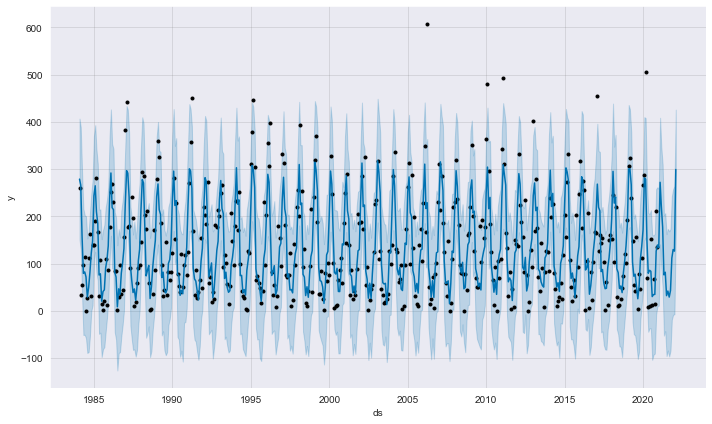

In [12]:
final_model = model.plot(rainfall_pred)

## Visualizando os Dados da Série Global e a Comparação entre Teste e Previsão

In [13]:
previsao = rainfall_pred[['ds','yhat']].iloc[-14:]
previsao.columns = ['Date','Precipitation']
previsao = previsao.round(1)

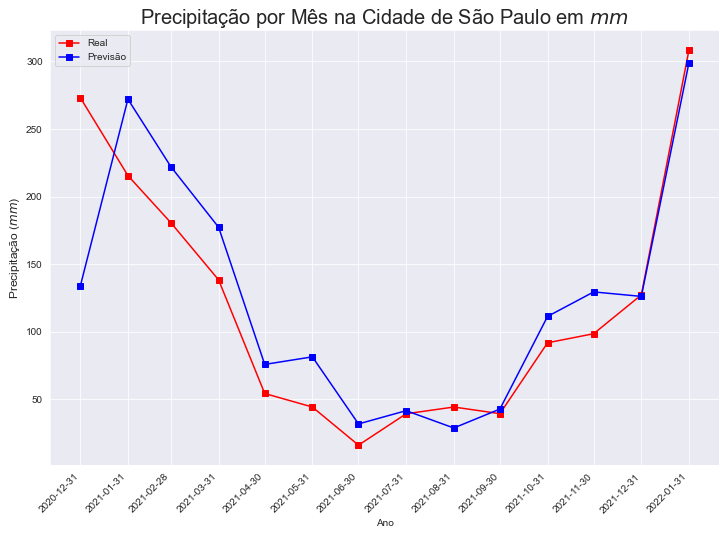

In [19]:
fig = plt.figure(figsize=(12, 8))

plt.plot(test.Date, test.Precipitation, 's-r')
plt.plot(previsao.Date, previsao.Precipitation, 's-b')

plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)

plt.ylabel('Precipitação ($mm$)', fontsize=12)
plt.xlabel('Ano')
plt.legend(['Real', 'Previsão']);

import matplotlib.dates as mdates 
months = mdates.MonthLocator(interval=1, bymonthday=-1)  
plt.gca().xaxis.set_major_locator(months) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xticks(rotation=45, ha='right') 
plt.show()

In [20]:
test #valores utilizados para testar o modelo (valores reais)

,Date,Precipitation
443,2020-12-31,273.2
444,2021-01-31,215.5
445,2021-02-28,180.6
446,2021-03-31,138.4
447,2021-04-30,54.4
448,2021-05-31,44.4
449,2021-06-30,16.2
450,2021-07-31,39.4
451,2021-08-31,44.4
452,2021-09-30,39.5


In [21]:
previsao #valores previstos pelo modelo

,Date,Precipitation
443,2020-12-31,133.7
444,2021-01-31,272.0
445,2021-02-28,222.0
446,2021-03-31,177.3
447,2021-04-30,75.9
448,2021-05-31,81.5
449,2021-06-30,31.9
450,2021-07-31,41.7
451,2021-08-31,28.9
452,2021-09-30,42.9


# Avaliando o Modelo

In [22]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [23]:
real_value = np.array(test['Precipitation'])
pred_value = np.array(previsao['Precipitation'])

In [24]:
smape = MeanAbsolutePercentageError(symmetric=True)
smape(real_value, pred_value) * 100

28.616357025060697